In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # For regular expressions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from scipy.sparse import hstack, csr_matrix
from collections import Counter
from wordcloud import WordCloud # Import WordCloud

# Suppress warnings for cleaner output (optional)
import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output (optional, good for presentations)
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd

# --- 1. Data Loading ---
print("--- 1. Data Loading ---")
try:
    # Use the 'python' engine for more robust parsing of malformed CSVs
    df_train = pd.read_csv(r'/content/drugsComTrain_raw.csv', engine='python')
    df_test = pd.read_csv(r'/content/drugsComTest_raw.csv', engine='python')
    print("Train and Test datasets loaded successfully.")
except FileNotFoundError:
    print("Error: Make sure 'drugsComTrain_raw.csv' and 'drugsComTest_raw.csv' are in the correct directory.")
    # Exit or handle the error appropriately if files are not found
    exit()
except pd.errors.ParserError as e:
    print(f"A parsing error occurred: {e}")
    print("This often happens due to unclosed quotes or other malformed data in the CSV file.")
    print("The 'python' engine was used, which is more robust, but the error still persisted.")
    exit()

print(f"\nTrain dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")

--- 1. Data Loading ---
Train and Test datasets loaded successfully.

Train dataset shape: (161297, 7)
Test dataset shape: (53766, 7)


In [5]:
# --- 2. Initial Data Inspection ---
print("\n--- 2. Initial Data Inspection (Train Data) ---")
print("\nTrain Data Head:")
print(df_train.head())


--- 2. Initial Data Inspection (Train Data) ---

Train Data Head:
   uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9  20-May-12   
1  "My son is halfway through his fourth week of ...       8  27-Apr-10   
2  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3  "This is my first time using any form of birth...       8  03-Nov-15   
4  "Suboxone has completely turned my life around...       9  27-Nov-16   

   usefulCount  
0           27  
1          192  
2   

In [6]:
print("\nTrain Data Info:")
df_train.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [7]:
print("\nTrain Data Description:")
print(df_train.describe(include='all'))


Train Data Description:
             uniqueID        drugName      condition  review         rating  \
count   161297.000000          161297         160398  161297  161297.000000   
unique            NaN            3436            884  112329            NaN   
top               NaN  Levonorgestrel  Birth Control  "Good"            NaN   
freq              NaN            3657          28788      33            NaN   
mean    115923.585305             NaN            NaN     NaN       6.994377   
std      67004.445170             NaN            NaN     NaN       3.272329   
min          2.000000             NaN            NaN     NaN       1.000000   
25%      58063.000000             NaN            NaN     NaN       5.000000   
50%     115744.000000             NaN            NaN     NaN       8.000000   
75%     173776.000000             NaN            NaN     NaN      10.000000   
max     232291.000000             NaN            NaN     NaN      10.000000   

             date    usefu

In [8]:
print("\n--- 2. Initial Data Inspection (Test Data) ---")
print("\nTest Data Head:")
print(df_test.head())


--- 2. Initial Data Inspection (Test Data) ---

Test Data Head:
   uniqueID         drugName                     condition  \
0    163740      Mirtazapine                    Depression   
1    206473       Mesalamine  Crohn's Disease, Maintenance   
2    159672          Bactrim       Urinary Tract Infection   
3     39293         Contrave                   Weight Loss   
4     97768  Cyclafem 1 / 35                 Birth Control   

                                              review  rating       date  \
0  "I&#039;ve tried a few antidepressants over th...      10  28-Feb-12   
1  "My son has Crohn&#039;s disease and has done ...       8  17-May-09   
2                      "Quick reduction of symptoms"       9  29-Sep-17   
3  "Contrave combines drugs that were used for al...       9  05-Mar-17   
4  "I have been on this birth control for one cyc...       9  22-Oct-15   

   usefulCount  
0           22  
1           17  
2            3  
3           35  
4            4  


In [9]:
print("\nTest Data Info:")
df_test.info()


Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uniqueID     53766 non-null  int64 
 1   drugName     53766 non-null  object
 2   condition    53471 non-null  object
 3   review       53766 non-null  object
 4   rating       53766 non-null  int64 
 5   date         53766 non-null  object
 6   usefulCount  53766 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 2.9+ MB


In [10]:
print("\nTest Data Description:")
print(df_test.describe(include='all'))


Test Data Description:
             uniqueID        drugName      condition   review        rating  \
count    53766.000000           53766          53471    53766  53766.000000   
unique            NaN            2637            708    48280           NaN   
top               NaN  Levonorgestrel  Birth Control  "Good."           NaN   
freq              NaN            1273           9648        8           NaN   
mean    116386.701187             NaN            NaN      NaN      6.976900   
std      67017.739881             NaN            NaN      NaN      3.285207   
min          0.000000             NaN            NaN      NaN      1.000000   
25%      58272.500000             NaN            NaN      NaN      4.000000   
50%     116248.500000             NaN            NaN      NaN      8.000000   
75%     174586.750000             NaN            NaN      NaN     10.000000   
max     232284.000000             NaN            NaN      NaN     10.000000   

             date   usefulC

In [11]:
# --- 3. Missing Value Analysis ---
print("\n--- 3. Missing Value Analysis ---")
print("\nMissing values in Train dataset:")
print(df_train.isnull().sum())
print("\nPercentage of missing values in Train dataset:")
print(df_train.isnull().sum() / len(df_train) * 100)


--- 3. Missing Value Analysis ---

Missing values in Train dataset:
uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

Percentage of missing values in Train dataset:
uniqueID       0.000000
drugName       0.000000
condition      0.557357
review         0.000000
rating         0.000000
date           0.000000
usefulCount    0.000000
dtype: float64


In [12]:
print("\nMissing values in Test dataset:")
print(df_test.isnull().sum())
print("\nPercentage of missing values in Test dataset:")
print(df_test.isnull().sum() / len(df_test) * 100)


Missing values in Test dataset:
uniqueID         0
drugName         0
condition      295
review           0
rating           0
date             0
usefulCount      0
dtype: int64

Percentage of missing values in Test dataset:
uniqueID       0.000000
drugName       0.000000
condition      0.548674
review         0.000000
rating         0.000000
date           0.000000
usefulCount    0.000000
dtype: float64


In [13]:
# --- 4. Target Variable Analysis (Train Data - 'condition') ---
print("\n--- 4. Target Variable Analysis ('condition') ---")
print(f"\nNumber of unique conditions: {df_train['condition'].nunique()}")

top_n_conditions = 20 # You can adjust this number
print(f"\nTop {top_n_conditions} conditions by count:")
print(df_train['condition'].value_counts().head(top_n_conditions))


--- 4. Target Variable Analysis ('condition') ---

Number of unique conditions: 884

Top 20 conditions by count:
condition
Birth Control                28788
Depression                    9069
Pain                          6145
Anxiety                       5904
Acne                          5588
Bipolar Disorde               4224
Insomnia                      3673
Weight Loss                   3609
Obesity                       3568
ADHD                          3383
Diabetes, Type 2              2554
Emergency Contraception       2463
High Blood Pressure           2321
Vaginal Yeast Infection       2274
Abnormal Uterine Bleeding     2096
Bowel Preparation             1859
ibromyalgia                   1791
Smoking Cessation             1780
Migraine                      1694
Anxiety and Stress            1663
Name: count, dtype: int64


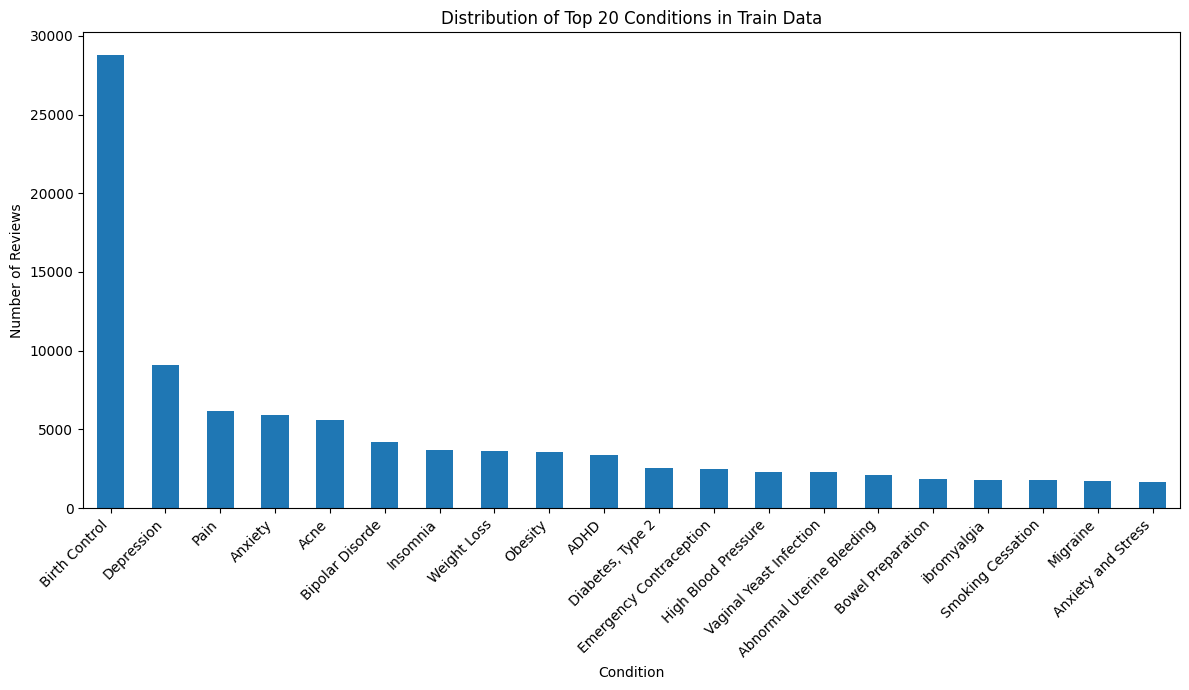

In [14]:
# Visualize the distribution of the top conditions
plt.figure(figsize=(12, 7))
df_train['condition'].value_counts().head(top_n_conditions).plot(kind='bar')
plt.title(f'Distribution of Top {top_n_conditions} Conditions in Train Data')
plt.xlabel('Condition')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [15]:
# Analyze conditions with very few samples
rare_conditions_threshold = 10 # Example threshold, adjust as needed
rare_conditions = df_train['condition'].value_counts()
rare_conditions_df = rare_conditions[rare_conditions < rare_conditions_threshold]
print(f"\nNumber of conditions with less than {rare_conditions_threshold} reviews: {len(rare_conditions_df)}")
if len(rare_conditions_df) > 0:
    print("Sample of rare conditions:")
    print(rare_conditions_df.head())



Number of conditions with less than 10 reviews: 450
Sample of rare conditions:
condition
Costochondritis                                9
23</span> users found this comment helpful.    9
Menopausal Disorders                           9
TSH Suppression                                9
Local Anesthesia                               9
Name: count, dtype: int64


In [16]:
# --- 5. Feature Analysis ---
print("\n--- 5. Feature Analysis ---")

# drugName
print(f"\nNumber of unique drug names in Train: {df_train['drugName'].nunique()}")
print(f"Top 10 most common drugs in Train:")
print(df_train['drugName'].value_counts().head(10))


--- 5. Feature Analysis ---

Number of unique drug names in Train: 3436
Top 10 most common drugs in Train:
drugName
Levonorgestrel                        3657
Etonogestrel                          3336
Ethinyl estradiol / norethindrone     2850
Nexplanon                             2156
Ethinyl estradiol / norgestimate      2117
Ethinyl estradiol / levonorgestrel    1888
Phentermine                           1543
Sertraline                            1360
Escitalopram                          1292
Mirena                                1242
Name: count, dtype: int64



Rating distribution in Train:
rating
1     21619
2      6931
3      6513
4      5012
5      8013
6      6343
7      9456
8     18890
9     27531
10    50989
Name: count, dtype: int64


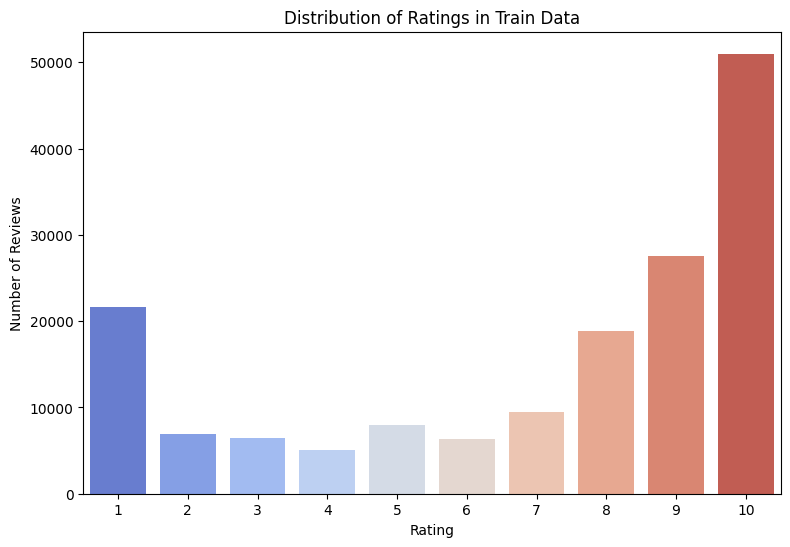

In [17]:
# rating
print("\nRating distribution in Train:")
print(df_train['rating'].value_counts().sort_index())
plt.figure(figsize=(9, 6))
sns.countplot(x='rating', data=df_train, palette='coolwarm')
plt.title('Distribution of Ratings in Train Data')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

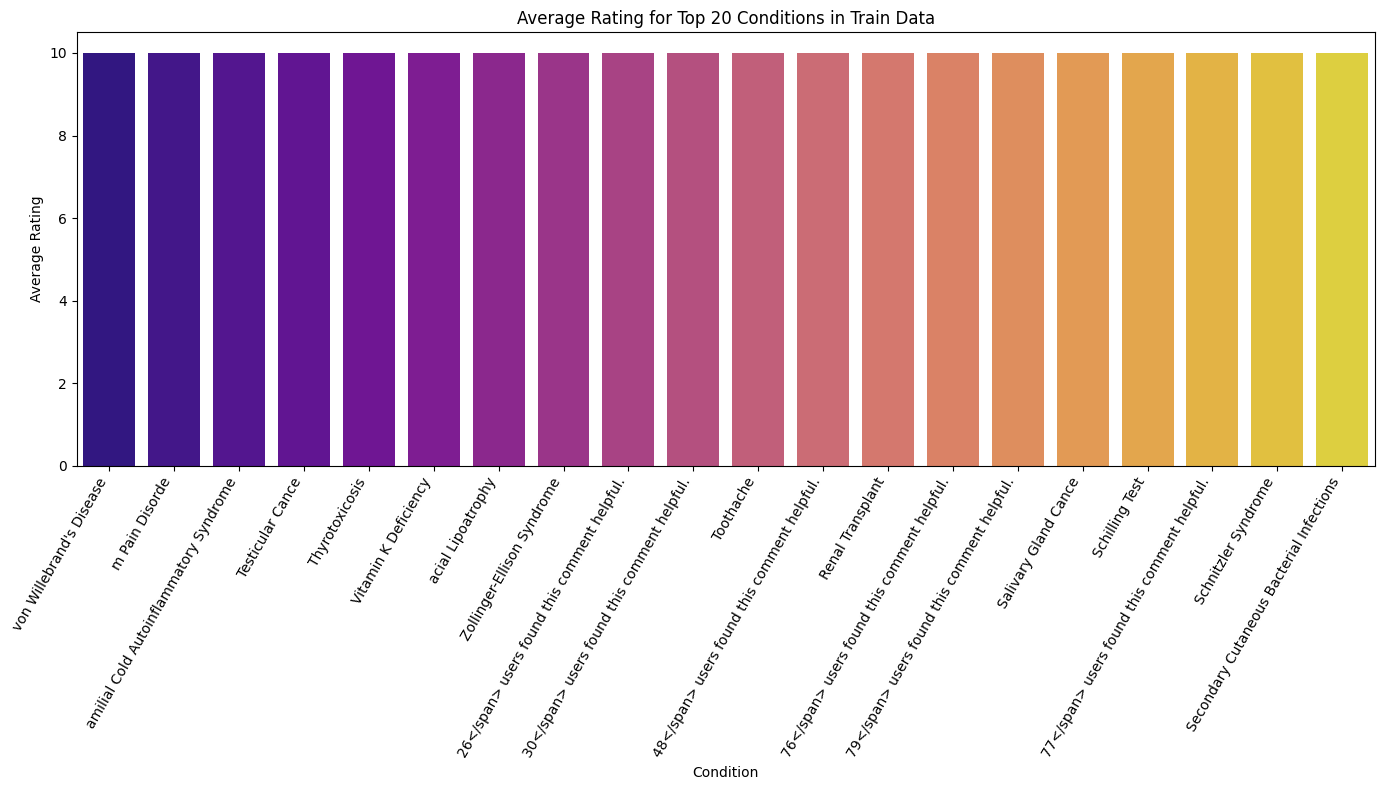

In [18]:
# Relationship between rating and condition (e.g., average rating per top condition)
plt.figure(figsize=(14, 8))
avg_rating_per_condition = df_train.groupby('condition')['rating'].mean().sort_values(ascending=False)
sns.barplot(x=avg_rating_per_condition.head(top_n_conditions).index, y=avg_rating_per_condition.head(top_n_conditions).values, palette='plasma')
plt.title(f'Average Rating for Top {top_n_conditions} Conditions in Train Data')
plt.xlabel('Condition')
plt.ylabel('Average Rating')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


Review Lengths (before preprocessing) in Train:
count    161297.000000
mean        458.726238
std         242.130235
min           3.000000
25%         262.000000
50%         455.000000
75%         691.000000
max       10787.000000
Name: review_length, dtype: float64


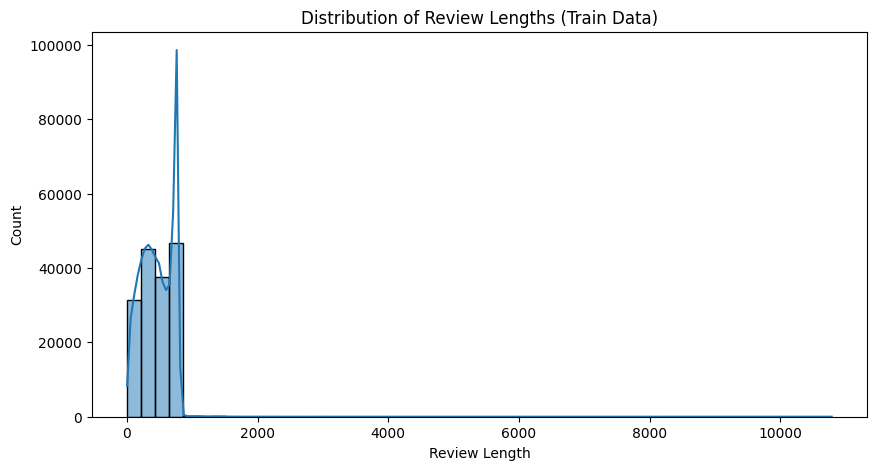

In [19]:
# Review length analysis (initial, before cleaning)
df_train['review_length'] = df_train['review'].astype(str).apply(len)
print("\nReview Lengths (before preprocessing) in Train:")
print(df_train['review_length'].describe())
plt.figure(figsize=(10, 5))
sns.histplot(df_train['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths (Train Data)')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()


Useful Count distribution in Train:
count    161297.000000
mean         28.004755
std          36.403742
min           0.000000
25%           6.000000
50%          16.000000
75%          36.000000
max        1291.000000
Name: usefulCount, dtype: float64


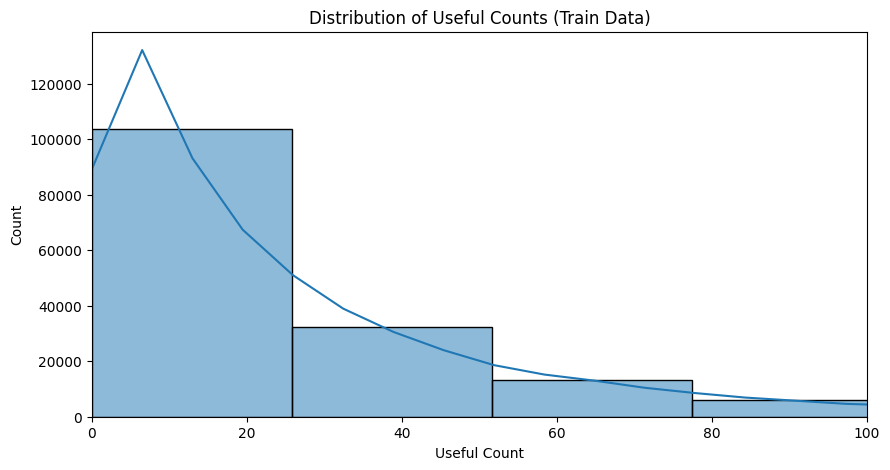

In [20]:
# usefulCount
print("\nUseful Count distribution in Train:")
print(df_train['usefulCount'].describe())
plt.figure(figsize=(10, 5))
sns.histplot(df_train['usefulCount'], bins=50, kde=True)
plt.title('Distribution of Useful Counts (Train Data)')
plt.xlabel('Useful Count')
plt.ylabel('Count')
plt.xlim(0, 100) # Limiting x-axis for better visualization of common counts
plt.show()

In [21]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

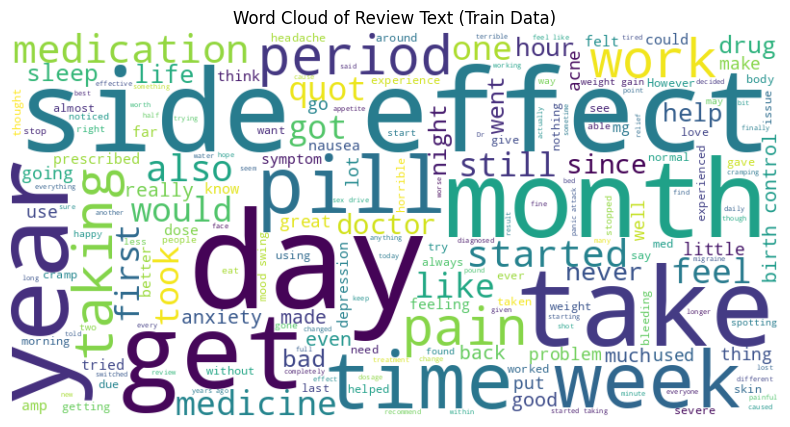

In [22]:
# Word cloud (after initial text cleaning, before full preprocessing)
# For this, let's take a sample of reviews to avoid performance issues with very large text
from wordcloud import WordCloud
all_reviews_text = ' '.join(df_train['review'].astype(str).sample(n=min(len(df_train), 5000), random_state=42).tolist()) # Sample 5000 reviews or all if less
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(all_reviews_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Review Text (Train Data)')
plt.show()


Review Lengths (before preprocessing) in Train:
count    161297.000000
mean        458.726238
std         242.130235
min           3.000000
25%         262.000000
50%         455.000000
75%         691.000000
max       10787.000000
Name: review_length, dtype: float64

Review Lengths (before preprocessing) in Test:
count    53766.000000
mean       458.304282
std        237.559635
min          3.000000
25%        262.000000
50%        457.000000
75%        689.000000
max       6192.000000
Name: review_length, dtype: float64


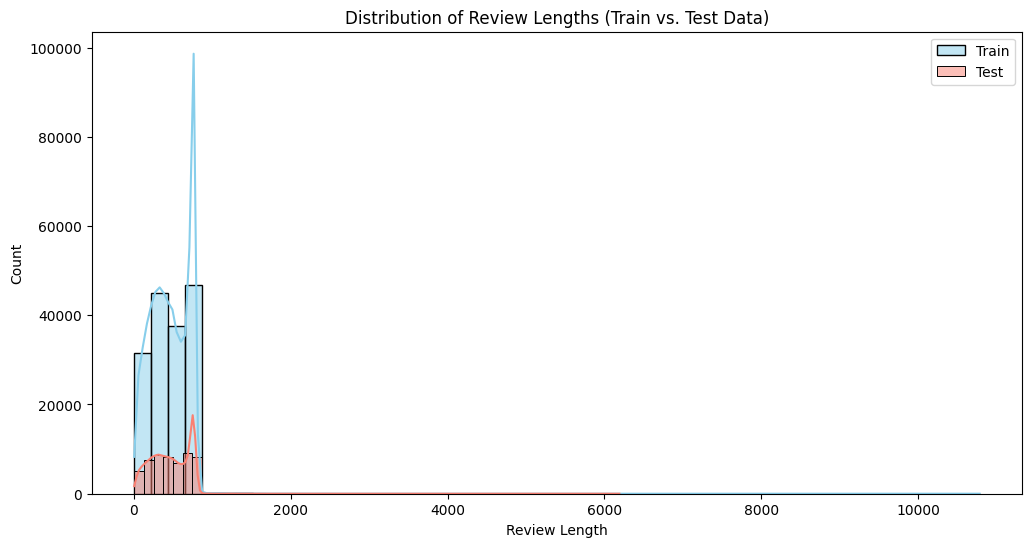

In [23]:
# review length analysis (before cleaning)
df_train['review_length'] = df_train['review'].astype(str).apply(len)
df_test['review_length'] = df_test['review'].astype(str).apply(len) # Also for test for comparison

print("\nReview Lengths (before preprocessing) in Train:")
print(df_train['review_length'].describe())
print("\nReview Lengths (before preprocessing) in Test:")
print(df_test['review_length'].describe())

plt.figure(figsize=(12, 6))
sns.histplot(df_train['review_length'], bins=50, kde=True, color='skyblue', label='Train')
sns.histplot(df_test['review_length'], bins=50, kde=True, color='salmon', label='Test')
plt.title('Distribution of Review Lengths (Train vs. Test Data)')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.legend()
plt.show()


In [24]:
# date (convert to datetime and analyze temporal trends)
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

print("\nDate range in Train:")
print(f"Min Date: {df_train['date'].min()}")
print(f"Max Date: {df_train['date'].max()}")
print("\nDate range in Test:")
print(f"Min Date: {df_test['date'].min()}")
print(f"Max Date: {df_test['date'].max()}")


Date range in Train:
Min Date: 2008-02-24 00:00:00
Max Date: 2017-12-12 00:00:00

Date range in Test:
Min Date: 2008-02-25 00:00:00
Max Date: 2017-12-12 00:00:00


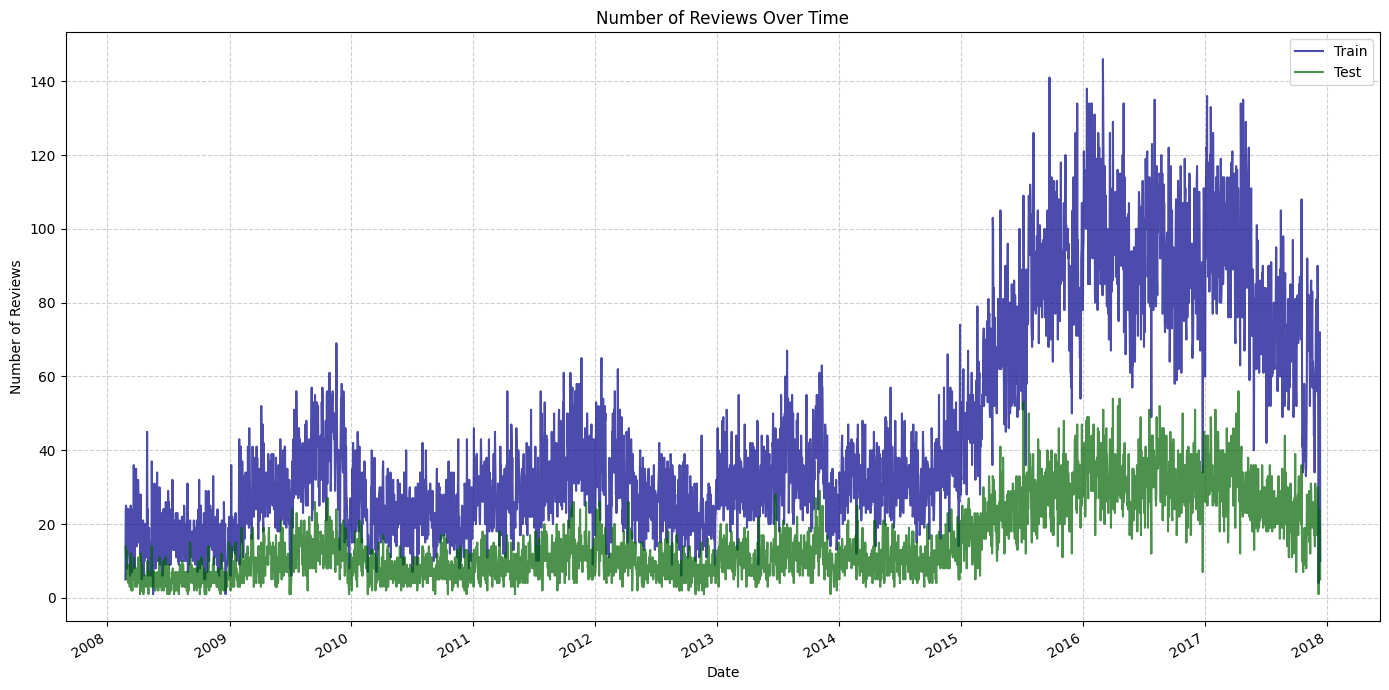

In [25]:
# Plot reviews over time
plt.figure(figsize=(14, 7))
df_train['date'].value_counts().sort_index().plot(label='Train', color='darkblue', alpha=0.7)
df_test['date'].value_counts().sort_index().plot(label='Test', color='darkgreen', alpha=0.7)
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [26]:
# Drop the temporary 'review_length' column
df_train.drop(columns=['review_length'], inplace=True)

print("\nInitial data exploration complete. Proceeding to preprocessing.")


Initial data exploration complete. Proceeding to preprocessing.


In [27]:
# --- 2. Handling Missing Values ---
print("\n--- 2. Handling Missing Values ---")

# For 'condition' (target variable), it's best to drop rows with missing values
# since we cannot reliably infer the target without prior knowledge.
initial_train_rows = df_train.shape[0]
df_train.dropna(subset=['condition'], inplace=True)
rows_dropped_train = initial_train_rows - df_train.shape[0]
print(f"Dropped {rows_dropped_train} rows from Train due to missing 'condition'.")

initial_test_rows = df_test.shape[0]
df_test.dropna(subset=['condition'], inplace=True)
rows_dropped_test = initial_test_rows - df_test.shape[0]
print(f"Dropped {rows_dropped_test} rows from Test due to missing 'condition'.")

print(f"\nTrain dataset shape after dropping missing 'condition': {df_train.shape}")
print(f"Test dataset shape after dropping missing 'condition': {df_test.shape}")



--- 2. Handling Missing Values ---
Dropped 899 rows from Train due to missing 'condition'.
Dropped 295 rows from Test due to missing 'condition'.

Train dataset shape after dropping missing 'condition': (160398, 7)
Test dataset shape after dropping missing 'condition': (53471, 8)


In [28]:
# For 'review' and 'drugName', fill NaN with 'unknown' or empty string
# An empty string is better for text processing as it won't be tokenized.
df_train['review'].fillna('', inplace=True)
df_test['review'].fillna('', inplace=True)
df_train['drugName'].fillna('unknown', inplace=True)
df_test['drugName'].fillna('unknown', inplace=True)

In [29]:
print("\nMissing values after handling:")
print("Train:")
print(df_train.isnull().sum())
print("\nTest:")
print(df_test.isnull().sum())


Missing values after handling:
Train:
uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

Test:
uniqueID         0
drugName         0
condition        0
review           0
rating           0
date             0
usefulCount      0
review_length    0
dtype: int64


In [30]:
# --- 3. Text Preprocessing Function ---
print("\n--- 3. Text Preprocessing ---")

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return "" # Handle non-string inputs by returning an empty string

    # 1. Convert to lowercase
    text = text.lower()

    # 2. Remove HTML tags (if any, though less common in this dataset)
    text = re.sub(r'<.*?>', '', text)

    # 3. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 4. Remove numbers and punctuation (keeping only alphabetic characters)
    # This also handles special characters.
    text = re.sub(r'[^a-z\s]', '', text)

    # 5. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # 6. Tokenization
    tokens = nltk.word_tokenize(text)

    # 7. Remove stop words and Lemmatization
    processed_tokens = [
        lemmatizer.lemmatize(word) for word in tokens if word not in stop_words
    ]

    # Join tokens back into a string
    return ' '.join(processed_tokens)


--- 3. Text Preprocessing ---


In [31]:
# Apply preprocessing to 'review' column in both train and test datasets
print("Applying text preprocessing to 'review' column (this may take a few moments)...")
df_train['processed_review'] = df_train['review'].apply(preprocess_text)
df_test['processed_review'] = df_test['review'].apply(preprocess_text)

print("\nSample of original vs. processed reviews (Train):")
for i in range(3):
    print(f"\nOriginal: {df_train['review'].iloc[i]}")
    print(f"Processed: {df_train['processed_review'].iloc[i]}")

Applying text preprocessing to 'review' column (this may take a few moments)...

Sample of original vs. processed reviews (Train):

Original: "It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"
Processed: side effect take combination bystolic mg fish oil

Original: "My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. 
We have tried many different medications and s

In [32]:
# --- 4. Feature Engineering: Text Vectorization (TF-IDF) ---
print("\n--- 4. Feature Engineering: Text Vectorization (TF-IDF) ---")

# Initialize TF-IDF Vectorizer
# max_features: limits the number of features (vocabulary size)
# min_df: Ignores words that appear in less than 5 documents (adjust as needed)
# max_df: Ignores words that appear in more than 80% of documents (adjust as needed)
tfidf_vectorizer = TfidfVectorizer(max_features=10000, min_df=5, max_df=0.8)


--- 4. Feature Engineering: Text Vectorization (TF-IDF) ---


In [33]:
# Fit on training data and transform both train and test data
X_train_text_features = tfidf_vectorizer.fit_transform(df_train['processed_review'])
X_test_text_features = tfidf_vectorizer.transform(df_test['processed_review'])

In [34]:
print(f"\nShape of TF-IDF features for Train: {X_train_text_features.shape}")
print(f"Shape of TF-IDF features for Test: {X_test_text_features.shape}")


Shape of TF-IDF features for Train: (160398, 10000)
Shape of TF-IDF features for Test: (53471, 10000)


In [35]:
# --- 6. Feature Engineering: Numerical Features ---
print("\n--- 6. Feature Engineering: Numerical Features ---")

# --- MODIFICATION START: Replacing One-Hot Encoding with Frequency Encoding for drugName ---

# Calculate frequencies from the training data ONLY to prevent data leakage
drug_frequency_map = df_train['drugName'].value_counts(normalize=True).to_dict()

# Apply frequency encoding to both train and test sets
# If a drugName in test is not in train, it will get 0 or a small default frequency.
df_train['drugName_freq'] = df_train['drugName'].map(drug_frequency_map).fillna(0) # fillna(0) for drugs not in train
df_test['drugName_freq'] = df_test['drugName'].map(drug_frequency_map).fillna(0) # fillna(0) for drugs not in train

# Instead of OHE matrices, we now have a single frequency column
X_train_drug_feature = df_train[['drugName_freq']].values
X_test_drug_feature = df_test[['drugName_freq']].values

print(f"Shape of drugName Frequency features for Train: {X_train_drug_feature.shape}")
print(f"Shape of drugName Frequency features for Test: {X_test_drug_feature.shape}")

# Rating feature remains the same
X_train_rating = df_train['rating'].values.reshape(-1, 1)
X_test_rating = df_test['rating'].values.reshape(-1, 1)


--- 6. Feature Engineering: Numerical Features ---
Shape of drugName Frequency features for Train: (160398, 1)
Shape of drugName Frequency features for Test: (53471, 1)


In [36]:
# --- 7. Combine All Features ---
print("\n--- 7. Combine All Features ---")

# Convert the numerical features (drugName_freq and rating) to sparse matrices
# This ensures all components for hstack are sparse, which is generally more memory-efficient
# for large matrices and consistent with TF-IDF output.
X_train_drug_feature_sparse = csr_matrix(X_train_drug_feature)
X_test_drug_feature_sparse = csr_matrix(X_test_drug_feature)

X_train_rating_sparse = csr_matrix(X_train_rating)
X_test_rating_sparse = csr_matrix(X_test_rating)

# Combine all features using hstack
X_train_combined = hstack([X_train_text_features, X_train_drug_feature_sparse, X_train_rating_sparse])
X_test_combined = hstack([X_test_text_features, X_test_drug_feature_sparse, X_test_rating_sparse])

print(f"\nShape of combined features for Train: {X_train_combined.shape}")
print(f"Shape of combined features for Test: {X_test_combined.shape}")

y_train = df_train['condition']
y_test = df_test['condition']

print("\nFeatures and target variables are prepared for modeling.")



--- 7. Combine All Features ---

Shape of combined features for Train: (160398, 10002)
Shape of combined features for Test: (53471, 10002)

Features and target variables are prepared for modeling.


In [ ]:
# --- 8. Model Selection & Training (Baseline Model - Logistic Regression) ---
print("\n--- 8. Model Selection & Training (Baseline Model - Logistic Regression) ---")

log_reg_model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42, n_jobs=-1, class_weight='balanced')

print("Training Logistic Regression model...")
log_reg_model.fit(X_train_combined, y_train)
print("Model training complete.")



--- 8. Model Selection & Training (Baseline Model - Logistic Regression) ---
Training Logistic Regression model...


In [ ]:
# --- 9. Model Evaluation ---
print("\n--- 9. Model Evaluation ---")

y_pred_train = log_reg_model.predict(X_train_combined)
y_pred_test = log_reg_model.predict(X_test_combined)

print("\n--- Training Set Evaluation ---")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print("\nClassification Report:")
print(classification_report(y_train, y_pred_train, zero_division=0))

print("\n--- Test Set Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, zero_division=0))

print("\n--- End of Baseline Model ---")